# Google Summer of Code Midterm Submission
## Improving Renaissance Spanish OCR with CNN-RNN Hybrids and Weighted Learning
### Kate O'Reilly, Trinity College Dublin

Package Installation

In [1]:
!pip install -r requirements.txt

^C


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
   --------- ------------------------------ 2.6/11.4 MB 11.6 MB/s eta 0:00:01
   -------------------- ------------------- 5.8/11.4 MB 11.4 MB/s eta 0:00:01
   ---------------------------- ----------- 8.1/11.4 MB 11.4 MB/s eta 0:00:01
   ------------------------------------- -- 10.7/11.4 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.4 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.4 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.4 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.4 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------- 11.4/11.4 MB 6.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ------------- -------------------------- 2.6/7.8 

Reason for being yanked: So that users won't accidentally install this when using python 3.11
  DEPRECATION: Building 'promise' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'promise'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\katej\\OneDrive\\Documents\\GitHub\\RenAIssance_fork\\cleanenv\\Lib\\site-packages\\tensorflow\\python\\keras\\saving\\model_config.py'
Check the permissions.



In [1]:
!pip install numpy==1.23.5 


  Using cached numpy-1.23.5-cp39-cp39-win_amd64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp39-cp39-win_amd64.whl (14.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.23.5 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
torchmetrics 1.7.2 requires torch>=2.0.0, but you have torch 1.10.2 which is incompatible.


Import Modules

In [ ]:
# Data Pre-processing
import fitz
import cv2
import csv
import os
from docx import Document
import torch
import string
import requests
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from IPython.display import clear_output as cls
from pathlib import Path

# Data
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#Update the path to your data directory
DATA_DIR = Path("data/")

If using the corrected data from Dataset_Preprocessing, you will need to invert the images

In [ ]:
from utils import invert_images_in_folder
                
invert_images_in_folder(DATA_DIR, DATA_DIR)

Inverted: (para.png
Inverted: (por.png
Inverted: (que (2).png
Inverted: (que.png
Inverted: 13.png
Inverted: 14.png
Inverted: 20.png
Inverted: 6.png
Inverted: 8.png
Inverted: A (10).png
Inverted: a (11).png
Inverted: a (12).png
Inverted: a (13).png
Inverted: a (14).png
Inverted: a (15).png
Inverted: a (16).png
Inverted: a (17).png
Inverted: a (18).png
Inverted: a (19).png
Inverted: a (2).png
Inverted: a (20).png
Inverted: a (21).png
Inverted: a (22).png
Inverted: a (23).png
Inverted: a (24).png
Inverted: a (25).png
Inverted: a (26).png
Inverted: a (27).png
Inverted: a (28).png
Inverted: a (29).png
Inverted: a (3).png
Inverted: a (30).png
Inverted: a (31).png
Inverted: a (32).png
Inverted: a (33).png
Inverted: a (34).png
Inverted: a (35).png
Inverted: a (36).png
Inverted: a (37).png
Inverted: a (38).png
Inverted: a (39).png
Inverted: a (4).png
Inverted: a (40).png
Inverted: A (5).png
Inverted: a (6).png
Inverted: a (7).png
Inverted: a (8).png
Inverted: a (9).png
Inverted: a.png
Inverted:

Fix any Decoding Errors from Spanish Glyphs in Filenames

In [ ]:
import os
folder = DATA_DIR

for filename in os.listdir(folder):
    try:
        # Fix the mojibake filename
        corrected = filename.encode('latin1').decode('utf-8')
        src = os.path.join(folder, filename)
        dst = os.path.join(folder, corrected)

        if src != dst:
            if not os.path.exists(dst):
                os.rename(src, dst)
                print(f"Renamed: {filename} → {corrected}")
            else:
                print(f"Skipped (already exists): {corrected}")
    except UnicodeDecodeError:
        print(f"Skipped (decode error): {filename}")


Skipped (decode error): aquí.png
Skipped (already exists): años.png
Skipped (decode error): año.png
Skipped (decode error): años, (2).png
Skipped (decode error): años,.png
Skipped (decode error): años..png
Skipped (decode error): años.png
Skipped (decode error): daños.png
Skipped (decode error): dañoso.png
Skipped (decode error): despeña,.png
Skipped (already exists): enseñar.png
Skipped (decode error): enseñados.png
Skipped (decode error): enseñan.png
Skipped (decode error): enseñanza.png
Skipped (decode error): enseñar.png
Skipped (decode error): enseñeis.png
Skipped (decode error): enseño.png
Skipped (decode error): España.png
Skipped (decode error): estrañan.png
Skipped (decode error): estén.png
Skipped (decode error): gañan.png
Skipped (decode error): grá.png
Skipped (decode error): hallarán.png
Skipped (decode error): manifestó.png
Skipped (decode error): maña.png
Skipped (already exists): niñez.png
Skipped (already exists): niño.png
Skipped (already exists): niños (2).png
Skippe

Create CSV with Filename and Identity

In [52]:
from utils import create_csv_from_folder

create_csv_from_folder(DATA_DIR, "csv/train.csv")
create_csv_from_folder("data/test_data/", "csv/test.csv")

CSV created at csv/train.csv with 4171 entries.
CSV created at csv/test.csv with 163 entries.


Create Validation CSV

In [53]:
from sklearn.model_selection import train_test_split

# Load full CSV
full_df = pd.read_csv("csv/train.csv")

# Split (e.g., 90% train, 10% val)
train_df, val_df = train_test_split(full_df, test_size=0.1, random_state=42, shuffle=True)

# Save new CSVs
train_df.to_csv("csv/train.csv", index=False)
val_df.to_csv("csv/val.csv", index=False)

print(f"[INFO] Training set: {len(train_df)} samples")
print(f"[INFO] Validation set: {len(val_df)} samples")


[INFO] Training set: 3753 samples
[INFO] Validation set: 418 samples


Remove Filenames and Identities for Missing Images

In [54]:
from utils import clean_csv_missing_images

clean_csv_missing_images("csv/train.csv", image_column="FILENAME")
clean_csv_missing_images("csv/val.csv", image_column="FILENAME")

No missing image files found.
Cleaned CSV saved to: csv/train.csv
No missing image files found.
Cleaned CSV saved to: csv/val.csv


,FILENAME,IDENTITY
0,data\outputCorrected (5)\outputCorrected\la (1...,la
1,data\outputCorrected (5)\outputCorrected\tiern...,tierna
2,data\outputCorrected (5)\outputCorrected\jufta...,juftamete
3,data\outputCorrected (5)\outputCorrected\hijo ...,hijo
4,data\outputCorrected (5)\outputCorrected\uno.png,uno
...,...,...
413,data\outputCorrected (5)\outputCorrected\su (1...,su
414,data\outputCorrected (5)\outputCorrected\te (5...,te
415,data\outputCorrected (5)\outputCorrected\gover...,governo
416,data\outputCorrected (5)\outputCorrected\vicio...,vicio


Model Configurations

In [55]:
IMG_HEIGHT = 32
IMG_WIDTH = 128
BATCH_SIZE = 32
HIDDEN_SIZE = 256
NUM_EPOCHS = 20

In [56]:
import pandas as pd

# Load data
train_df = pd.read_csv("csv/train.csv")
val_df = pd.read_csv("csv/val.csv")

# Build CHARSET from all data
all_text = ''.join(train_df['IDENTITY'].astype(str)) + ''.join(val_df['IDENTITY'].astype(str))
CHARSET = ''.join(sorted(set(all_text)))

print(f"[INFO] Character Set ({len(CHARSET)}): {repr(CHARSET)}")

# Build mappings
char_to_idx = {char: idx + 1 for idx, char in enumerate(CHARSET)}  # 0 is CTC blank
idx_to_char = {idx + 1: char for idx, char in enumerate(CHARSET)}
idx_to_char[0] = ''  # blank token for CTC


[INFO] Character Set (55): ' ABCDEFGHIKLMNOPQRSTUVXYZabcdefghijlmnopqrstuvxyzáéíñóú'


In [57]:
with open("charset.txt", "r", encoding="utf-8") as f:
    CHARSET = f.read()

char_to_idx = {char: idx + 1 for idx, char in enumerate(CHARSET)}  # CTC blank = 0
idx_to_char = {idx + 1: char for idx, char in enumerate(CHARSET)}
idx_to_char[0] = ''  # blank


In [58]:
def find_unknown_chars(df, charset):
    all_text = ''.join(df['IDENTITY'].dropna().astype(str))
    return sorted(set(all_text) - set(charset))

print("Unknowns in train:", find_unknown_chars(train_df, CHARSET))
print("Unknowns in val:", find_unknown_chars(val_df, CHARSET))


Unknowns in train: []
Unknowns in val: []


Dataset Configurations

In [59]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch
from pathlib import Path
from urllib.parse import unquote
import unicodedata
import pandas as pd

def normalize_path(path):
    path = Path(str(path))
    try:
        path = unquote(str(path).encode("latin1").decode("utf-8"))
    except Exception:
        path = str(path)
    return unicodedata.normalize("NFC", path)

class OCRDataset(Dataset):
    def __init__(self, csv_path, transform=None, char_to_idx=None):
        self.df = pd.read_csv(csv_path, quotechar='"')
        self.df["IDENTITY"] = self.df["IDENTITY"].astype(str).str.strip()
        self.df = self.df[
            self.df["IDENTITY"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0 and x.lower() != 'nan')
        ]

        self.transform = transform
        self.char_to_idx = char_to_idx  # <-- pass externally!

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = normalize_path(row['FILENAME'])
        label_str = unicodedata.normalize('NFC', str(row['IDENTITY']).strip())

        try:
            img = Image.open(img_path).convert("L")
        except Exception as e:
            raise FileNotFoundError(f"Could not open image: {img_path}\n{e}")

        img = img.resize((128, 32))
        img = np.array(img).astype(np.uint8)
        img = Image.fromarray(img, mode='L')

        if self.transform:
            img = self.transform(img)

        if self.char_to_idx is None:
            raise ValueError("char_to_idx mapping must be provided to OCRDataset.")
        label = [self.char_to_idx[c] for c in label_str if c in self.char_to_idx]
        return img, torch.tensor(label, dtype=torch.long), len(label), label_str


Collate Function

In [60]:
import torchvision.transforms as transforms

def collate_fn(batch):
    images, labels, label_lengths, label_strs = zip(*batch)

    # Ensure all images are tensors
    tensor_images = []
    for img in images:
        if not isinstance(img, torch.Tensor):
            img = transforms.ToTensor()(img)
        tensor_images.append(img)

    images = torch.stack(tensor_images)
    labels_concat = torch.cat(labels)
    label_lengths = torch.tensor(label_lengths, dtype=torch.long)

    return images, labels_concat, label_lengths, label_strs


CRNN Model (Custom Backbone)

In [61]:
class CRNN(nn.Module):
    def __init__(self, imgH, nc, nclass, nh):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0
        self.cnn = nn.Sequential(
            nn.Conv2d(nc, 64, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),                    # H: 32 → 16
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),                   # H: 16 → 8
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d((2, 2), (2, 1), (0, 1)), # H: 8 → 4
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1)),
            nn.AdaptiveAvgPool2d((1, None))                                             
        )

        self.rnn1 = nn.LSTM(512, nh, bidirectional=True)
        self.rnn2 = nn.LSTM(nh * 2, nh, bidirectional=True)
        
        self.embedding = nn.Linear(nh * 2, nclass)

    def forward(self, x):
        conv = self.cnn(x)

        b, c, h, w = conv.size()
        assert h == 1
        conv = conv.squeeze(2).permute(2, 0, 1)  # [w, b, c]
        rnn_out, _ = self.rnn1(conv)
        rnn_out, _ = self.rnn2(rnn_out)
        output = self.embedding(rnn_out)
        return output

Greedy Decoder

In [62]:
def decode(output):
    out = output.softmax(2)
    _, max_idx = out.max(2)
    max_idx = max_idx.transpose(1, 0)

    texts = []
    for pred in max_idx:
        pred = pred.cpu().numpy()
        chars = []
        prev = -1
        for p in pred:
            if p != prev and p != 0:
                chars.append(idx_to_char[p])
            prev = p
        texts.append(''.join(chars))
    return texts

Beam Decoder

In [63]:
def ctc_beam_search_decoder(probs, charset, beam_width=10, blank_index=0):
    T, C = probs.shape  # [T, C]
    beams = [("", 1.0)]  # list of (sequence, score)

    for t in range(T):
        new_beams = []
        for prefix, score in beams:
            for c in range(C):
                p = probs[t, c]
                new_seq = prefix + (charset[c] if c != blank_index else "")
                new_score = score * p
                new_beams.append((new_seq, new_score))
        # Keep top N beams
        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

    return beams[0][0]  # return best sequence


Training Utilities

In [64]:
def save_checkpoint(model, optimizer, epoch, path='crnn_checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

def load_checkpoint(model, optimizer, path='crnn_checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


Load Data

In [65]:
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)), 
    transforms.ToTensor(),                      
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

train_dataset = OCRDataset("csv/train.csv", transform=transform, char_to_idx=char_to_idx)
val_dataset = OCRDataset("csv/val.csv", transform=transform, char_to_idx=char_to_idx)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

Training Loop

In [66]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5, verbose=True
)


early_stopper = EarlyStopping(patience=5)
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels_concat, label_lengths, _ in train_loader:
        images = images.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)

        outputs = model(images)
        input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(DEVICE)

        loss = criterion(outputs.log_softmax(2), labels_concat, input_lengths, label_lengths.to(DEVICE))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels_concat, label_lengths, _ in val_loader:
            images = images.to(DEVICE)
            labels_concat = labels_concat.to(DEVICE)
            outputs = model(images)
            input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(DEVICE)
            loss = criterion(outputs.log_softmax(2), labels_concat, input_lengths, label_lengths.to(DEVICE))
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_checkpoint(model, optimizer, epoch, path='best_model.pth')
        print("Saved best model.")

    if early_stopper.step(avg_val_loss):
        print("Early stopping triggered.")
        break


Epoch 1, Train Loss: 3.9753, Val Loss: 3.2075
Saved best model.
Epoch 2, Train Loss: 3.1443, Val Loss: 3.0805
Saved best model.
Epoch 3, Train Loss: 3.0445, Val Loss: 2.9859
Saved best model.
Epoch 4, Train Loss: 2.7836, Val Loss: 2.8315
Saved best model.
Epoch 5, Train Loss: 2.1908, Val Loss: 1.8933
Saved best model.
Epoch 6, Train Loss: 1.3146, Val Loss: 1.0951
Saved best model.
Epoch 7, Train Loss: 0.8188, Val Loss: 0.8164
Saved best model.
Epoch 8, Train Loss: 0.6142, Val Loss: 0.5772
Saved best model.
Epoch 9, Train Loss: 0.4867, Val Loss: 0.5598
Saved best model.
Epoch 10, Train Loss: 0.4308, Val Loss: 0.4999
Saved best model.
Epoch 11, Train Loss: 0.3952, Val Loss: 0.4582
Saved best model.
Epoch 12, Train Loss: 0.3717, Val Loss: 0.5639
Epoch 13, Train Loss: 0.3387, Val Loss: 0.4286
Saved best model.
Epoch 14, Train Loss: 0.2952, Val Loss: 0.4362
Epoch 15, Train Loss: 0.2955, Val Loss: 0.4960
Epoch 16, Train Loss: 0.2847, Val Loss: 0.4480
Epoch 17, Train Loss: 0.2516, Val Loss: 0

Further Train

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)

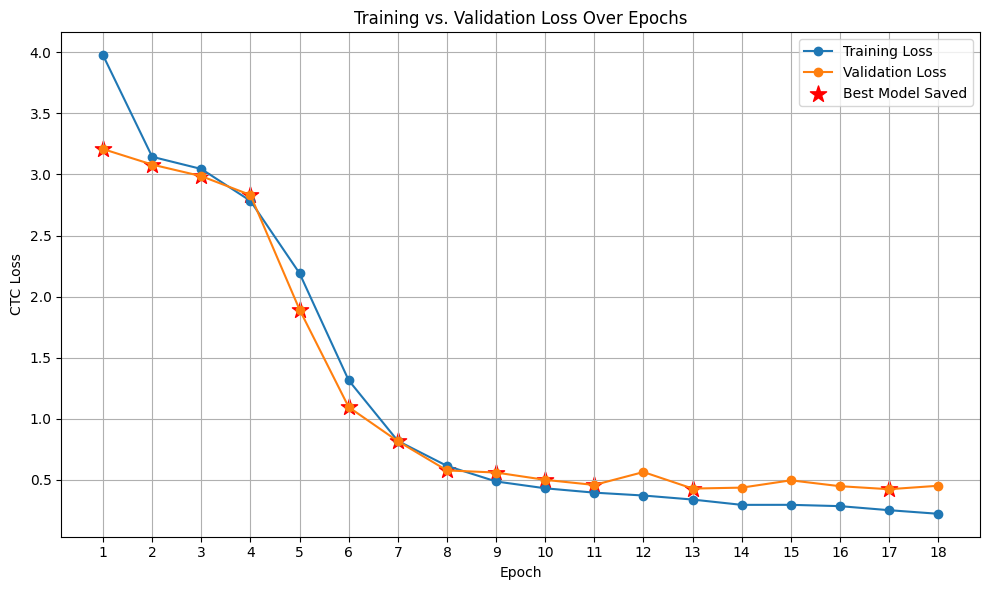

In [ ]:
import matplotlib.pyplot as plt

# Manually Extract training and validation losses
train_losses = [
    3.9753, 3.1443, 3.0445, 2.7836, 2.1908, 1.3146,
    0.8188, 0.6142, 0.4867, 0.4308, 0.3952, 0.3717,
    0.3387, 0.2952, 0.2955, 0.2847, 0.2516, 0.2221
]

val_losses = [
    3.2075, 3.0805, 2.9859, 2.8315, 1.8933, 1.0951,
    0.8164, 0.5772, 0.5598, 0.4999, 0.4582, 0.5639,
    0.4286, 0.4362, 0.4960, 0.4480, 0.4233, 0.4516
]

# Best epochs where the model was saved
best_epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 17]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')

# Highlight best validation points
best_val_losses = [val_losses[i - 1] for i in best_epochs]
best_val_epochs = [i - 1 for i in best_epochs]
plt.scatter(best_val_epochs, best_val_losses, color='red', marker='*', s=150, label='Best Model Saved')

plt.title('Training vs. Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('CTC Loss')
plt.xticks(range(len(train_losses)), range(1, len(train_losses) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Visual Evaluation

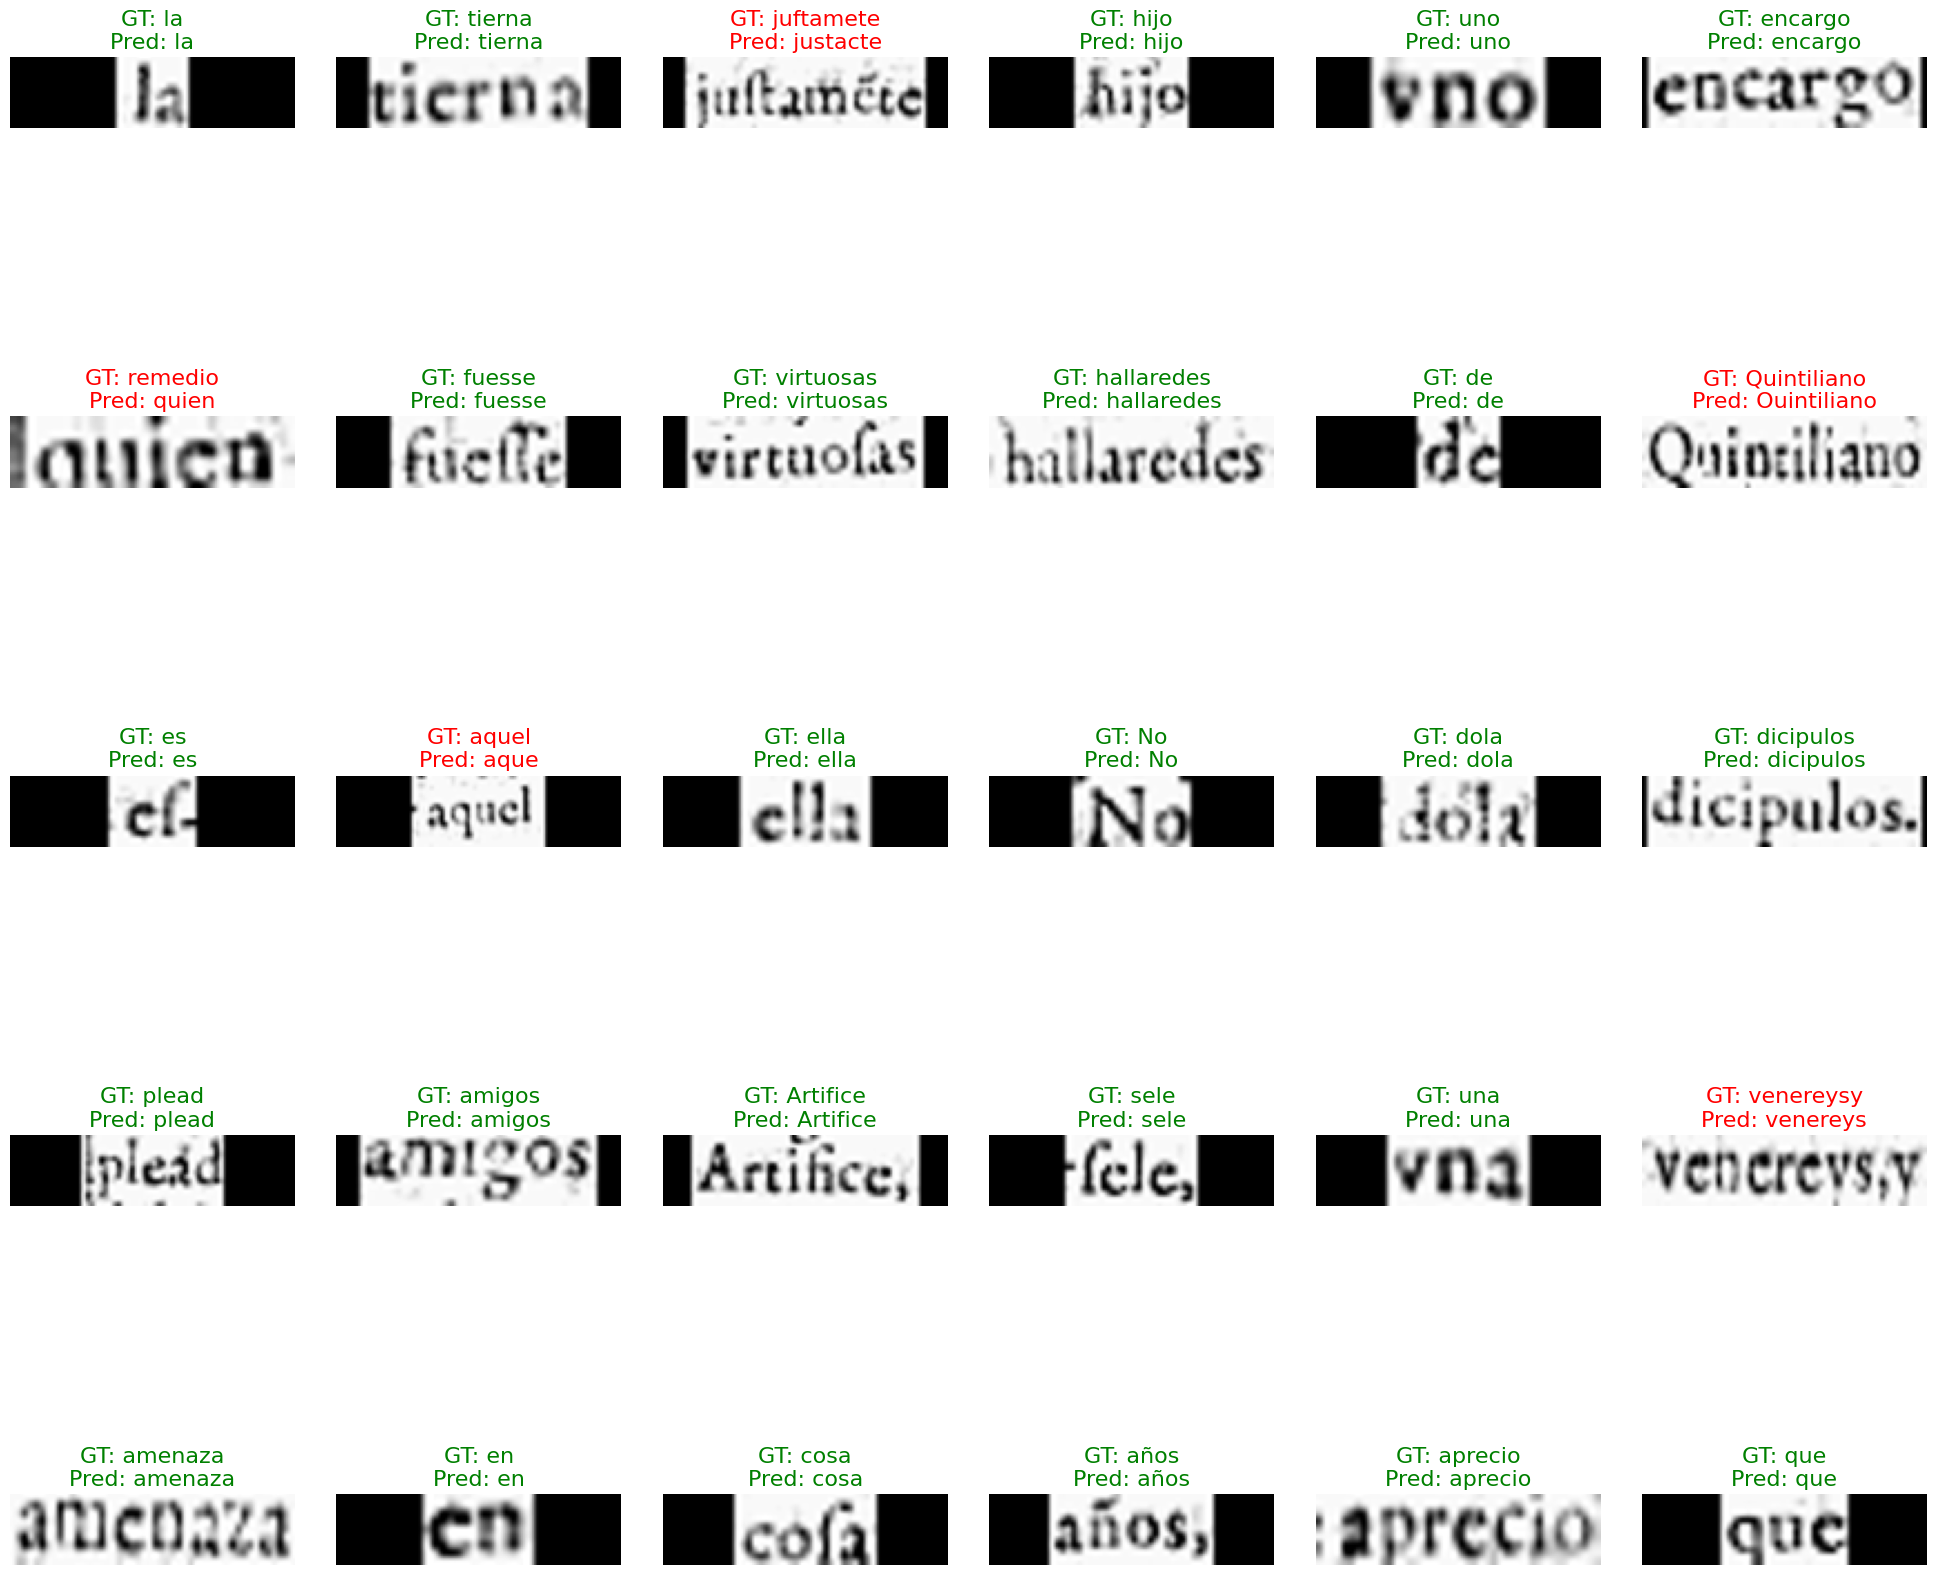

In [68]:
import torch
import matplotlib.pyplot as plt
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild the model and load saved weights
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()


with torch.no_grad():
    images, _, _, label_strs = next(iter(val_loader))
    images = images.to(DEVICE)
    outputs = model(images)
    preds = decode(outputs)

    num_images = min(30, len(images))
    cols = 6
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(20, rows * 4))

    for i in range(num_images):
        img_np = images[i].cpu().squeeze().numpy() * 0.5 + 0.5
        gt = label_strs[i]
        pred = preds[i]
        correct = (gt == pred)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_np, cmap='gray')

        title_color = 'green' if correct else 'red'
        plt.title(f"GT: {gt}\nPred: {pred}", fontsize=16, color=title_color)
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()


In [ ]:
import torch
import numpy as np
from collections import defaultdict
from jiwer import cer, wer

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild and load model
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Evaluation on full validation set
gt_texts = []
greedy_preds = []
beam_preds = []

with torch.no_grad():
    for images, _, _, label_strs in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        log_probs = outputs.log_softmax(2).cpu()

        T, B, C = log_probs.shape
        greedy_preds.extend(decode(log_probs))

        for b in range(B):
            probs_np = log_probs[:, b, :].exp().numpy()
            beam_pred = ctc_beam_search_decoder(probs_np, CHARSET, beam_width=5)
            beam_preds.append(beam_pred)

        gt_texts.extend(label_strs)

# Global CER/WER
print(f"\nEvaluation on {len(gt_texts)} samples")
print(f"Greedy   CER: {cer(' '.join(gt_texts), ' '.join(greedy_preds)):.4f} | WER: {wer(' '.join(gt_texts), ' '.join(greedy_preds)):.4f}")
print(f"Beam     CER: {cer(' '.join(gt_texts), ' '.join(beam_preds)):.4f} | WER: {wer(' '.join(gt_texts), ' '.join(beam_preds)):.4f}")

# Per-sample CERs
print("\nPer-sample CER (first 20 shown):")
for i, (gt, g_pred, b_pred) in enumerate(zip(gt_texts, greedy_preds, beam_preds)):
    print(f"\nSample {i+1}")
    print(f"GT:     {gt}")
    print(f"Greedy: {g_pred}")
    print(f"  CER: {cer(gt, g_pred):.2f}")
    print(f"Beam:   {b_pred}")
    print(f"  CER: {cer(gt, b_pred):.2f}")
    if i >= 19:
        break  # Show first 20 samples only



Evaluation on 417 samples
Greedy   CER: 0.0730 | WER: 0.2278
Beam     CER: 0.0786 | WER: 0.2566

Per-sample CER (first 20 shown):

Sample 1
GT:     la
Greedy: la
  CER: 0.00
Beam:   la
  CER: 0.00

Sample 2
GT:     tierna
Greedy: tierna
  CER: 0.00
Beam:   tierna
  CER: 0.00

Sample 3
GT:     juftamete
Greedy: justacte
  CER: 0.33
Beam:   justacte
  CER: 0.33

Sample 4
GT:     hijo
Greedy: hijo
  CER: 0.00
Beam:   hijo
  CER: 0.00

Sample 5
GT:     uno
Greedy: uno
  CER: 0.00
Beam:   uno
  CER: 0.00

Sample 6
GT:     encargo
Greedy: encargo
  CER: 0.00
Beam:   encargo
  CER: 0.00

Sample 7
GT:     remedio
Greedy: quien
  CER: 0.86
Beam:   quien
  CER: 0.86

Sample 8
GT:     fuesse
Greedy: fuesse
  CER: 0.00
Beam:   fuese
  CER: 0.17

Sample 9
GT:     virtuosas
Greedy: virtuosas
  CER: 0.00
Beam:   virtuosas
  CER: 0.00

Sample 10
GT:     hallaredes
Greedy: hallaredes
  CER: 0.00
Beam:   halaredes
  CER: 0.10

Sample 11
GT:     de
Greedy: de
  CER: 0.00
Beam:   de
  CER: 0.00

Sample 1

Store Misidentified From the Val set for further incorporation later to target Specific Mischaracterisations.

In [71]:
import os
from torchvision.utils import save_image

# Create folder to store bad samples
os.makedirs("bad_preds", exist_ok=True)

model.eval()
failed_samples = []

with torch.no_grad():
    images, _, _, label_strs = next(iter(val_loader))
    images = images.to(DEVICE)
    outputs = model(images)
    preds = decode(outputs)

    for i in range(len(images)):
        gt = label_strs[i]
        pred = preds[i]
        correct = (gt == pred)

        # Save and log only incorrect predictions
        if not correct:
            img_tensor = images[i].cpu()
            filename = f"bad_preds/img_{i:03d}_GT_{gt}_PRED_{pred}.png"

            # Log in memory
            failed_samples.append({
                "index": i,
                "ground_truth": gt,
                "prediction": pred,
                "image_path": filename
            })

            # Save image to disk
            save_image(img_tensor, filename)

# Optional: view list of failed samples
for sample in failed_samples:
    print(f"[FAIL] GT: {sample['ground_truth']} | PRED: {sample['prediction']} → {sample['image_path']}")


[FAIL] GT: juftamete | PRED: justacte → bad_preds/img_002_GT_juftamete_PRED_justacte.png
[FAIL] GT: remedio | PRED: quien → bad_preds/img_006_GT_remedio_PRED_quien.png
[FAIL] GT: Quintiliano | PRED: Ouintiliano → bad_preds/img_011_GT_Quintiliano_PRED_Ouintiliano.png
[FAIL] GT: aquel | PRED: aque → bad_preds/img_013_GT_aquel_PRED_aque.png
[FAIL] GT: venereysy | PRED: venereys → bad_preds/img_023_GT_venereysy_PRED_venereys.png
[FAIL] GT: Religion | PRED: Relgioo → bad_preds/img_030_GT_Religion_PRED_Relgioo.png


Using Greedy Decode for Now

In [72]:
from jiwer import wer, cer

# After decoding
pred_texts = preds
gt_texts = list(label_strs)  # Convert tuple to list

# Compute average metrics
avg_cer = cer(gt_texts, pred_texts)
avg_wer = wer(gt_texts, pred_texts)

print(f"CER: {avg_cer:.4f} | WER: {avg_wer:.4f}")


CER: 0.0800 | WER: 0.1875


Bad Predictions CSV

In [75]:
import pandas as pd

df_bad = pd.DataFrame(failed_samples)  # from your earlier list
df_bad.to_csv("csv/bad_preds.csv", index=False)


In [76]:
class BadPredictionDataset(Dataset):
    def __init__(self, csv_path, transform, charset):
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.charset = charset
        self.char_to_idx = {c: i + 1 for i, c in enumerate(charset)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('L')
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        img = self.transform(img)
        label_str = row['ground_truth']
        label = [self.char_to_idx[c] for c in label_str if c in self.char_to_idx]
        return img, torch.tensor(label, dtype=torch.long), len(label), label_str


In [77]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

bad_dataset = BadPredictionDataset('data/bad_preds.csv', transform=transform, charset=CHARSET)
bad_loader = DataLoader(bad_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)



Add Spanish Dictionary to Beam Search

In [78]:
from pathlib import Path

# List of your dictionary files
dict_files = [
    "dictionaries/Diccionario.Espanol.136k.palabras.txt",
    "dictionaries/Diccionario.Espanol.no.special.characters.no.tilde.no.n.txt",
    "dictionaries/Diccionario.Espanol.no.special.characters.no.tilde.txt",
    "dictionaries/spanish_words.txt"
]

# Combine and clean
combined_words = set()
for file in dict_files:
    with open(file, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            word = line.strip().lower()
            if word:
                combined_words.add(word)

print(f"Combined dictionary size: {len(combined_words)}")

# Optionally save to a file
with open("combined_spanish_lexicon.txt", "w", encoding="utf-8") as f:
    for word in sorted(combined_words):
        f.write(f"{word}\n")


Combined dictionary size: 230192


In [79]:
import numpy as np
from difflib import SequenceMatcher
from unidecode import unidecode
from rapidfuzz import process, fuzz
from collections import defaultdict

def normalized_edit_distance(a, b):
    """Compute normalized edit distance (0.0 = perfect match, 1.0 = completely different)."""
    return 1 - SequenceMatcher(None, a, b).ratio()

# Precompute: bucket normalized lexicon by word length
def build_length_buckets(lexicon):
    buckets = defaultdict(list)
    for word in lexicon:
        norm = unidecode(word.lower())
        buckets[len(norm)].append((norm, word))
    return buckets

# --- Load Lexicon ---
try:
    with open("combined_spanish_lexicon.txt", "r", encoding="latin1") as f:
        SPANISH_WORDS = set(w.strip() for w in f if w.strip())
except Exception as e:
    print("Failed to load lexicon:", e)
    SPANISH_WORDS = set()

LEXICON_BUCKETS = build_length_buckets(SPANISH_WORDS)

def correct_with_lexicon(
    seq,
    lexicon_buckets,
    length_tolerance=0,
    min_similarity=87,
    min_word_len=0,
    prefix_agreement=0,  # new: how much of the prefix must agree
    verbose=False
):
    original_seq = seq  # preserve original casing
    seq = seq.strip()
    norm_seq = unidecode(seq.lower())
    seq_len = len(norm_seq)

    if seq_len < min_word_len:
        return seq

    candidates = []
    for l in range(seq_len - length_tolerance, seq_len + length_tolerance + 1):
        candidates.extend(lexicon_buckets.get(l, []))  # (normalized, original)

    if not candidates:
        return seq

    # Prefer exact normalized match
    for norm_word, orig_word in candidates:
        if norm_word == norm_seq:
            if orig_word.lower() == seq.lower():
                return original_seq
            return orig_word

    # Fuzzy match with filtering
    best = process.extractOne(
        norm_seq,
        [w[0] for w in candidates],
        scorer=fuzz.ratio,
        score_cutoff=min_similarity
    )

    if best:
        matched_norm, score, _ = best
        for norm_word, orig_word in candidates:
            if norm_word == matched_norm:
                # Reject if not enough prefix match
                prefix_len = int(seq_len * prefix_agreement)
                if not norm_seq.startswith(norm_word[:prefix_len]):
                    if verbose:
                        print(f"[SKIP] Prefix mismatch: '{seq}' vs '{orig_word}'")
                    continue

                if orig_word.lower() == seq.lower():
                    return original_seq
                if verbose:
                    print(f"[MATCH] '{seq}' → '{orig_word}' (score: {score})")
                return orig_word

    return seq



In [ ]:
import torch
import numpy as np
from collections import defaultdict
from jiwer import cer, wer
from unidecode import unidecode
from difflib import SequenceMatcher
from pathlib import Path

# --- Load Model ---
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# --- Load Lexicon ---
try:
    with open("combined_spanish_lexicon.txt", "r", encoding="latin1") as f:
        SPANISH_WORDS = set(w.strip().lower() for w in f if w.strip())
except Exception as e:
    print("Failed to load lexicon:", e)
    SPANISH_WORDS = set()

# --- Run Evaluation ---
gt_texts = []
beam_preds_no_lex = []
beam_preds_with_lex = []

with torch.no_grad():
    for images, _, _, label_strs in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        log_probs = outputs.log_softmax(2).cpu()
        T, B, C = log_probs.shape
        for b in range(B):
            probs_np = log_probs[:, b, :].exp().numpy()
            pred_no_lex = ctc_beam_search_decoder(probs_np, CHARSET, beam_width=5)
            pred_with_lex = correct_with_lexicon(pred_no_lex, LEXICON_BUCKETS)
            beam_preds_no_lex.append(pred_no_lex)
            beam_preds_with_lex.append(pred_with_lex)
        gt_texts.extend(label_strs)

# --- Report Results ---
print(f"\nEvaluation on {len(gt_texts)} samples")
print(f"Beam (no lexicon) CER: {cer(gt_texts, beam_preds_no_lex):.4f} | WER: {wer(gt_texts, beam_preds_no_lex):.4f}")
print(f"Beam (with lexicon)  CER: {cer(gt_texts, beam_preds_with_lex):.4f} | WER: {wer(gt_texts, beam_preds_with_lex):.4f}")



Evaluation on 417 samples
Beam (no lexicon) CER: 0.0940 | WER: 0.2566
Beam (with lexicon)  CER: 0.1006 | WER: 0.2710


In [82]:
from termcolor import colored
from jiwer import wer, cer

lexicon_helped = 0
lexicon_hurt = 0

print("\nLexicon Impact on Predictions:\n")
for gt, no_lex, with_lex in zip(gt_texts, beam_preds_no_lex, beam_preds_with_lex):
    if no_lex != with_lex:
        # Compute per-sample WER
        wer_no_lex = wer(gt, no_lex)
        wer_with_lex = wer(gt, with_lex)

        if wer_with_lex < wer_no_lex:
            color = "green"
            lexicon_helped += 1
        elif wer_with_lex > wer_no_lex:
            color = "red"
            lexicon_hurt += 1
        else:
            color = "yellow"

        print(colored(f"[GT]        {gt}", "cyan"))
        print(colored(f"[Beam]      {no_lex}", "magenta"))
        print(colored(f"[Lexicon]   {with_lex} (WER: {wer_with_lex:.2f})", color))
        print()

print(f"Lexicon improved {lexicon_helped} predictions.")
print(f"Lexicon worsened {lexicon_hurt} predictions.")
print(f"Unchanged or equal: {len(gt_texts) - lexicon_helped - lexicon_hurt}")



Lexicon Impact on Predictions:

[GT]        juftamete
[Beam]      justacte
[Lexicon]   ajustate (WER: 1.00)

[GT]        daños
[Beam]      daños
[Lexicon]   danos (WER: 1.00)

[GT]        apetece
[Beam]      apetecie
[Lexicon]   apetecer (WER: 1.00)

[GT]        trabajo
[Beam]      trabajos
[Lexicon]   trabamos (WER: 1.00)

[GT]        continuar
[Beam]      contintar
[Lexicon]   continuar (WER: 0.00)

[GT]        grangear
[Beam]      grangear
[Lexicon]   granjear (WER: 1.00)

[GT]        necesaria
[Beam]      hecesaria
[Lexicon]   necesaria (WER: 0.00)

[GT]        personas
[Beam]      personas
[Lexicon]   personar (WER: 1.00)

[GT]        entienden
[Beam]      enienden
[Lexicon]   entiende (WER: 1.00)

[GT]        importante
[Beam]      iportante
[Lexicon]   portantes (WER: 1.00)

[GT]        gallardia
[Beam]      galardia
[Lexicon]   gallarda (WER: 1.00)

[GT]        razon
[Beam]      pastores
[Lexicon]   pastoree (WER: 1.00)

[GT]        enamorados
[Beam]      enamorados
[Lexicon] 

Create New Dataset using New Data

In [ ]:
import gdown
import zipfile
import os

# Google Drive file ID of the ZIP file
DATA_DIR = 'data/Word.zip'

# Construct download URL
gdown.download(f'https://drive.google.com/file/1oPAjtp4aKGPXDksLSzU3WiCgj_m09ADB', DATA_DIR, quiet=False)

# Unzip the downloaded file
with zipfile.ZipFile(DATA_DIR, 'r') as zip_ref:
    zip_ref.extractall('unzipped_folder')

# Optional: remove the zip file after extraction
os.remove(DATA_DIR)

DATA_DIR = 'data/Word'


In [ ]:
from utils import pad_and_resize_images, create_csv_from_folder

pad_and_resize_images(DATA_DIR)
create_csv_from_folder(DATA_DIR, "csv/train_new_data.csv")

Processed: data/Word/Word\cropped\&.jpg
Processed: data/Word/Word\cropped\(47).jpg
Processed: data/Word/Word\cropped\(49).jpg
Processed: data/Word/Word\cropped\(51).jpg
Processed: data/Word/Word\cropped\(53).jpg
Processed: data/Word/Word\cropped\(55).jpg
Processed: data/Word/Word\cropped\(58).jpg
Processed: data/Word/Word\cropped\(6.jpg
Processed: data/Word/Word\cropped\(61.jpg
Processed: data/Word/Word\cropped\(aun.jpg
Processed: data/Word/Word\cropped\(Christianamen.jpg
Processed: data/Word/Word\cropped\(pero.jpg
Processed: data/Word/Word\cropped\, como.jpg
Processed: data/Word/Word\cropped\,acusado.jpg
Processed: data/Word/Word\cropped\,como_1.jpg
Processed: data/Word/Word\cropped\,como_2.jpg
Processed: data/Word/Word\cropped\,con.jpg
Processed: data/Word/Word\cropped\,de.jpg
Processed: data/Word/Word\cropped\,ne.jpg
Processed: data/Word/Word\cropped\,qui.jpg
Processed: data/Word/Word\cropped\,vel.jpg
Processed: data/Word/Word\cropped\1.per.jpg
Processed: data/Word/Word\cropped\109.

Combine with Previous CSV

In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Load all three sources ---
df1 = pd.read_csv("csv/train.csv")
df2 = pd.read_csv("csv/train_new_data.csv")
df_val = pd.read_csv("csv/val.csv")

# --- Combine all ---
combined_df = pd.concat([df1, df2, df_val], ignore_index=True)

# --- Clean up: remove missing or empty IDENTITYs ---
combined_df["IDENTITY"] = combined_df["IDENTITY"].astype(str).str.strip()
combined_df = combined_df[combined_df["IDENTITY"].astype(bool)]  # remove empty strings / NaN

# --- Optional: shuffle entire set ---
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
combined_df["FILENAME"] = combined_df["FILENAME"].apply(lambda x: str(Path(x).as_posix()))


# --- Split into 90% train, 10% val ---
train_df, val_df = train_test_split(combined_df, test_size=0.1, random_state=42)

# --- Save to disk ---
train_df.to_csv("csv/train_new.csv", index=False)
val_df.to_csv("csv/val_new.csv", index=False)

print(f"Final datasets:")
print(f" - train.csv: {len(train_df)} samples")
print(f" - val.csv:   {len(val_df)} samples")


Final datasets:
 - train.csv: 7507 samples
 - val.csv:   835 samples


New DataLoader

In [89]:
train_dataset = OCRDataset('csv/train_new.csv', transform=transform, char_to_idx=char_to_idx)
val_dataset = OCRDataset('csv/val_new.csv', transform=transform, char_to_idx=char_to_idx)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

Train on New Data

In [92]:
# Ensure DEVICE is defined
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)

# Load previous checkpoint
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
# Load all layers except the embedding layer (output layer)
state_dict = checkpoint["model_state_dict"]
model_state = model.state_dict()
# Remove embedding weights/bias if shape mismatch
for key in ["embedding.weight", "embedding.bias"]:
	if key in state_dict and model_state[key].shape != state_dict[key].shape:
		print(f"Skipping {key} due to shape mismatch: {model_state[key].shape} vs {state_dict[key].shape}")
		del state_dict[key]
model.load_state_dict(state_dict, strict=False)

# Optionally resume optimizer state (recommended for consistent learning rate behavior)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# Restore epoch number if needed:
start_epoch = checkpoint.get("epoch", 0) + 1


In [93]:

if model is None:
    raise ValueError("Model is not initialized. Please run the cell that initializes and loads the model before running this training loop.")

early_stopper = EarlyStopping(patience=5)
best_val_loss = float('inf')

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels_concat, label_lengths, _ in train_loader:
        images = images.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)

        outputs = model(images)
        if outputs is None:
            raise ValueError("Model forward() returned None. Check your CRNN forward method.")
        input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(DEVICE)
        loss = criterion(outputs.log_softmax(2), labels_concat, input_lengths, label_lengths.to(DEVICE))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels_concat, label_lengths, _ in val_loader:
            images = images.to(DEVICE)
            labels_concat = labels_concat.to(DEVICE)
            outputs = model(images)
            input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(DEVICE)
            loss = criterion(outputs.log_softmax(2), labels_concat, input_lengths, label_lengths.to(DEVICE))
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_checkpoint(model, optimizer, epoch, path='best_model.pth')
        print("Saved best model.")

    if early_stopper.step(avg_val_loss):
        print("Early stopping triggered.")
        break

Epoch 1, Train Loss: 0.2370, Val Loss: 0.2891
Saved best model.
Epoch 2, Train Loss: 0.2138, Val Loss: 0.2753
Saved best model.
Epoch 3, Train Loss: 0.2083, Val Loss: 0.2872
Epoch 4, Train Loss: 0.1774, Val Loss: 0.2435
Saved best model.
Epoch 5, Train Loss: 0.1530, Val Loss: 0.2395
Saved best model.
Epoch 6, Train Loss: 0.1478, Val Loss: 0.2411
Epoch 7, Train Loss: 0.1260, Val Loss: 0.2504


KeyboardInterrupt: 

In [36]:
import torch
import matplotlib.pyplot as plt
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild the model and load saved weights
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): Bat

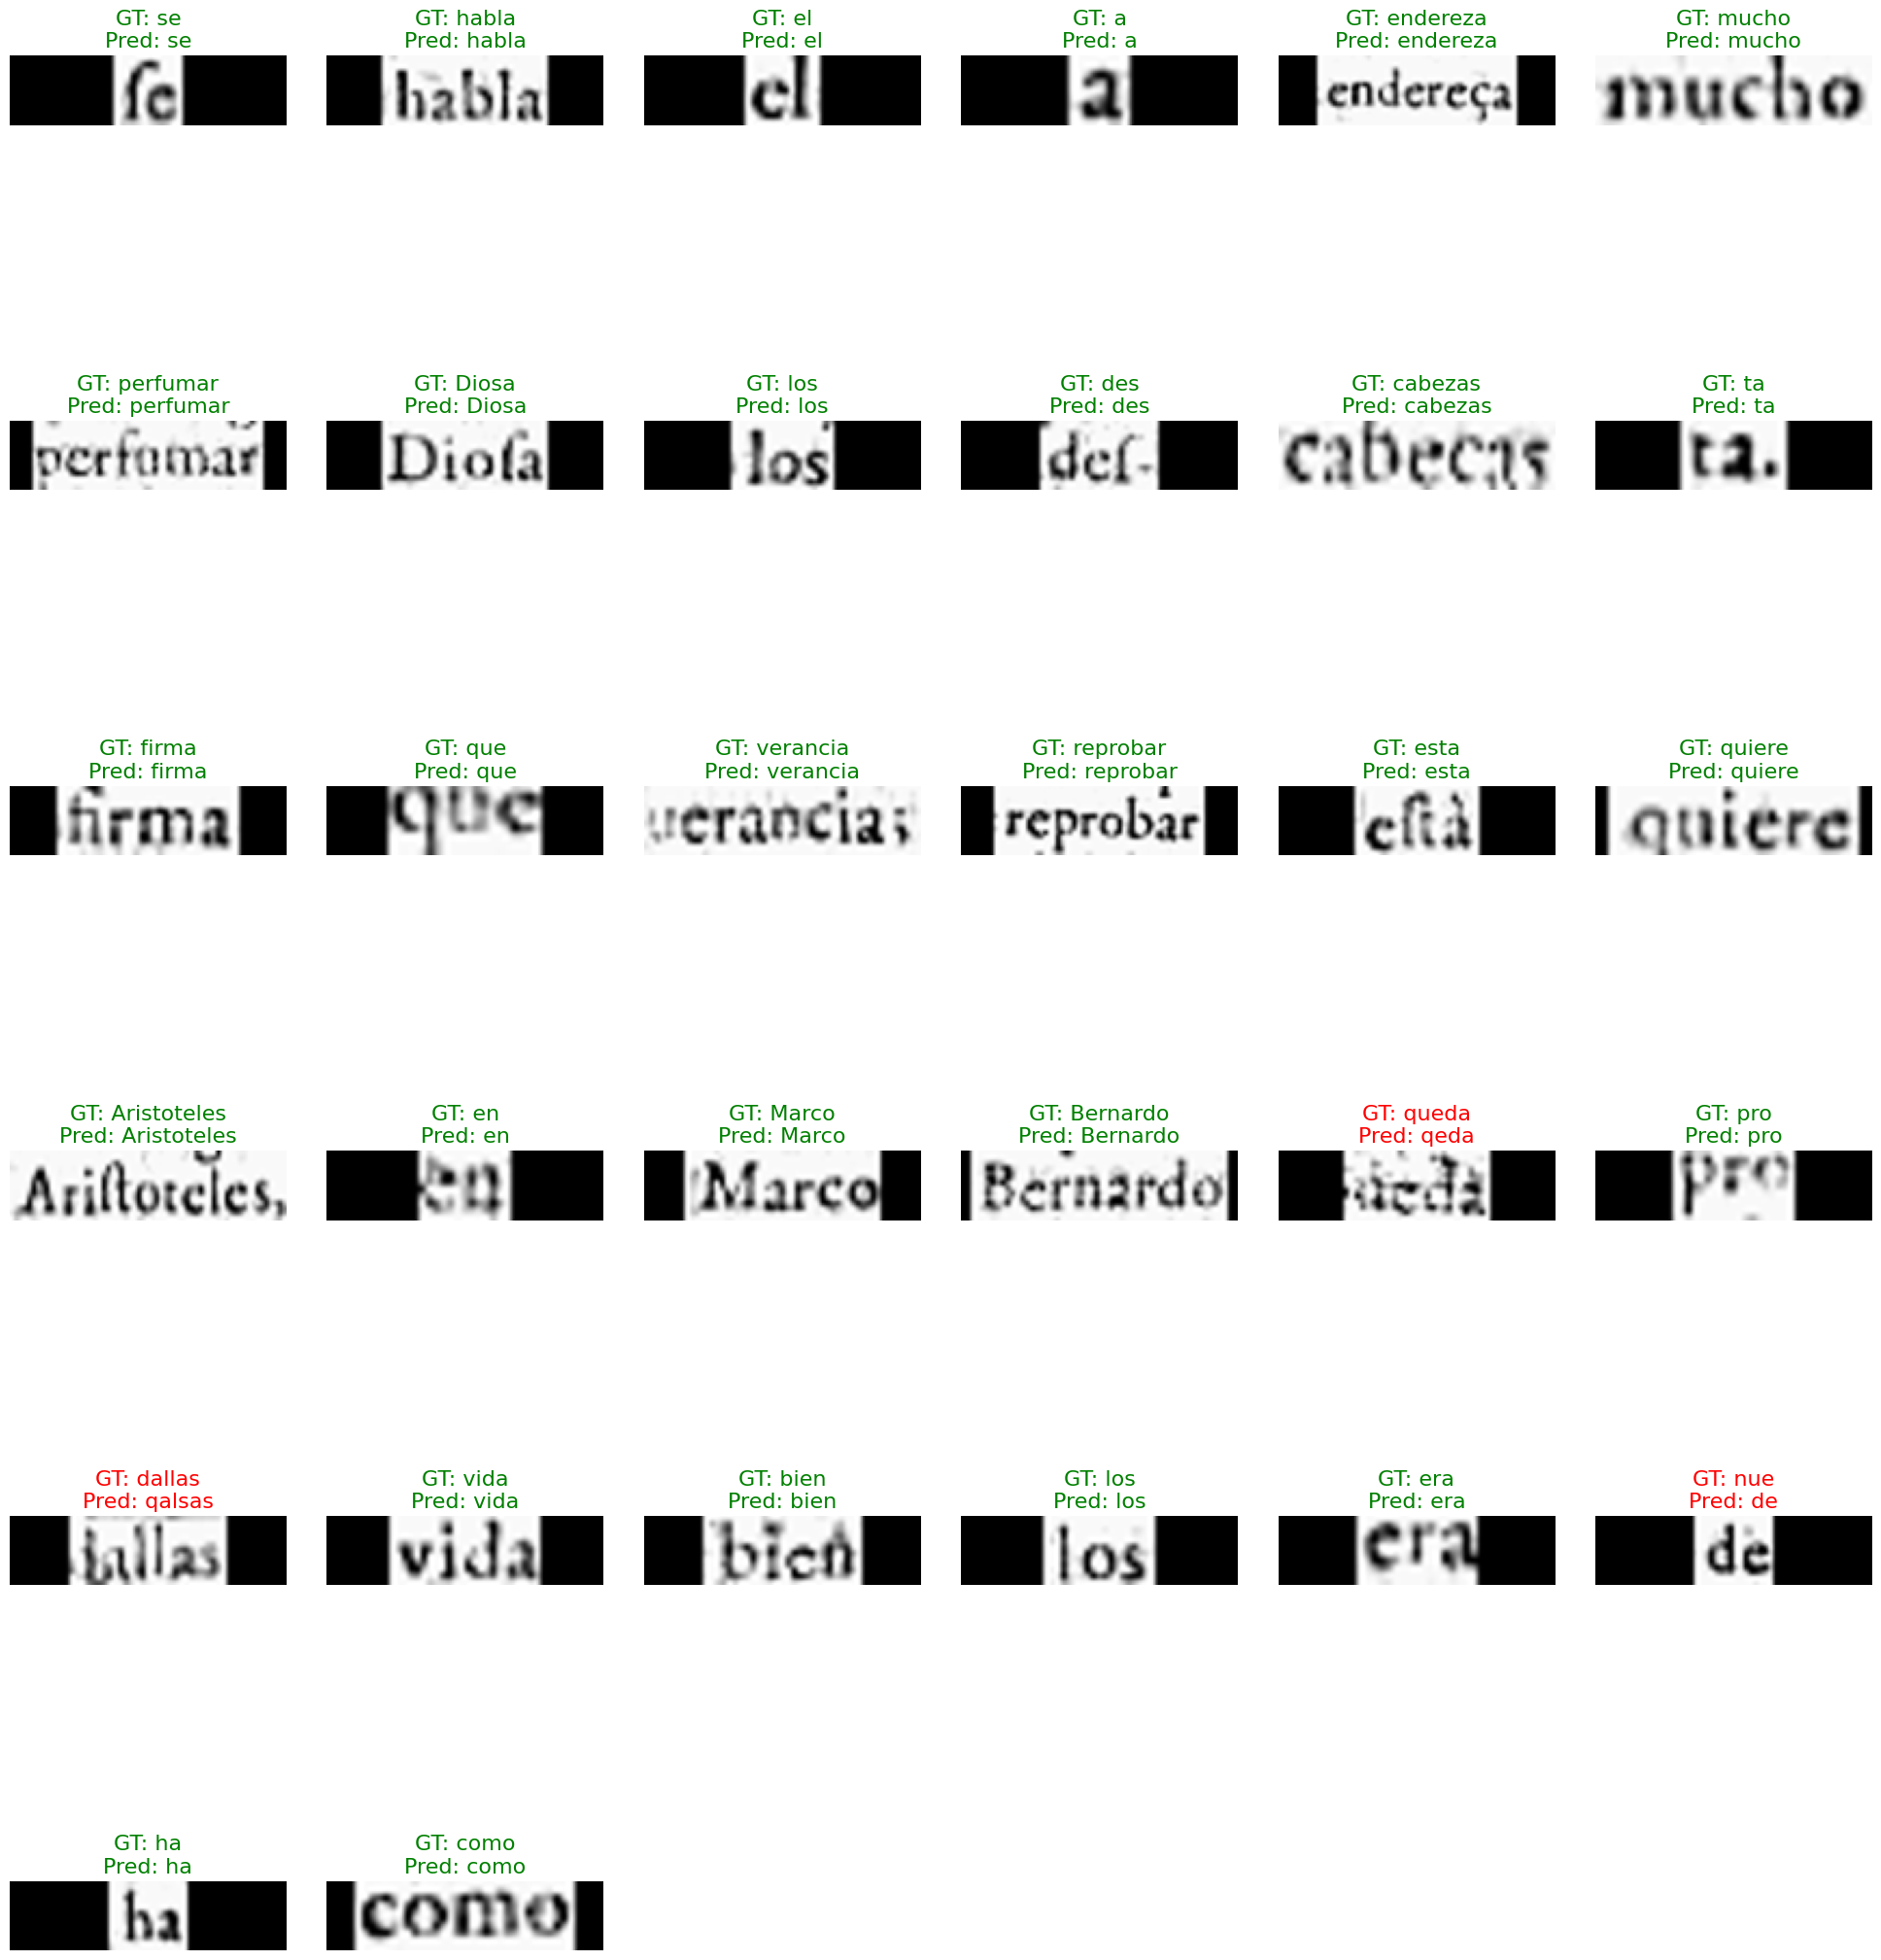

In [104]:
import torch
import matplotlib.pyplot as plt
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild the model and load saved weights
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

with torch.no_grad():
    images, _, _, label_strs = next(iter(val_loader))
    images = images.to(DEVICE)
    outputs = model(images)
    preds = decode(outputs)

    num_images = min(32, len(images))
    cols = 6
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(20, rows * 4))

    for i in range(num_images):
        img_np = images[i].cpu().squeeze().numpy() * 0.5 + 0.5
        gt = label_strs[i]
        pred = preds[i]
        correct = (gt == pred)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_np, cmap='gray')

        title_color = 'green' if correct else 'red'
        plt.title(f"GT: {gt}\nPred: {pred}", fontsize=16, color=title_color)
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()


FINAL CER AND WER 0.0338 0.0938

In [105]:
from jiwer import wer, cer

# After decoding
pred_texts = preds
gt_texts = list(label_strs)  # Convert tuple to list

# Ensure both lists are the same length
min_len = min(len(gt_texts), len(pred_texts))
gt_texts = gt_texts[:min_len]
pred_texts = pred_texts[:min_len]

# Compute average metrics
avg_cer = cer(gt_texts, pred_texts)
avg_wer = wer(gt_texts, pred_texts)

print(f"CER: {avg_cer:.4f} | WER: {avg_wer:.4f}")


CER: 0.0338 | WER: 0.0938


In [98]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class OCRTestDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, img_path  # return path to identify output


In [96]:
import pandas as pd
from pathlib import Path

# Load validation CSV
val_df = pd.read_csv("csv/val.csv")

# Only keep rows where the image file still exists
val_df = val_df[val_df["FILENAME"].apply(lambda x: Path(x).is_file())]

# Sample N examples
n = 100
sampled = val_df.sample(n=min(n, len(val_df)), random_state=42).reset_index(drop=True)

# Remove the FILENAME column to create a test CSV
test_df = sampled[['FILENAME']]
test_df.to_csv("csv/test.csv", index=False)

print(f"Created test.csv with {len(test_df)} entries from valid files.")


Created test.csv with 100 entries from valid files.


In [99]:
test_dataset = OCRTestDataset('csv/test.csv', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Test Model on Unlabelled Data

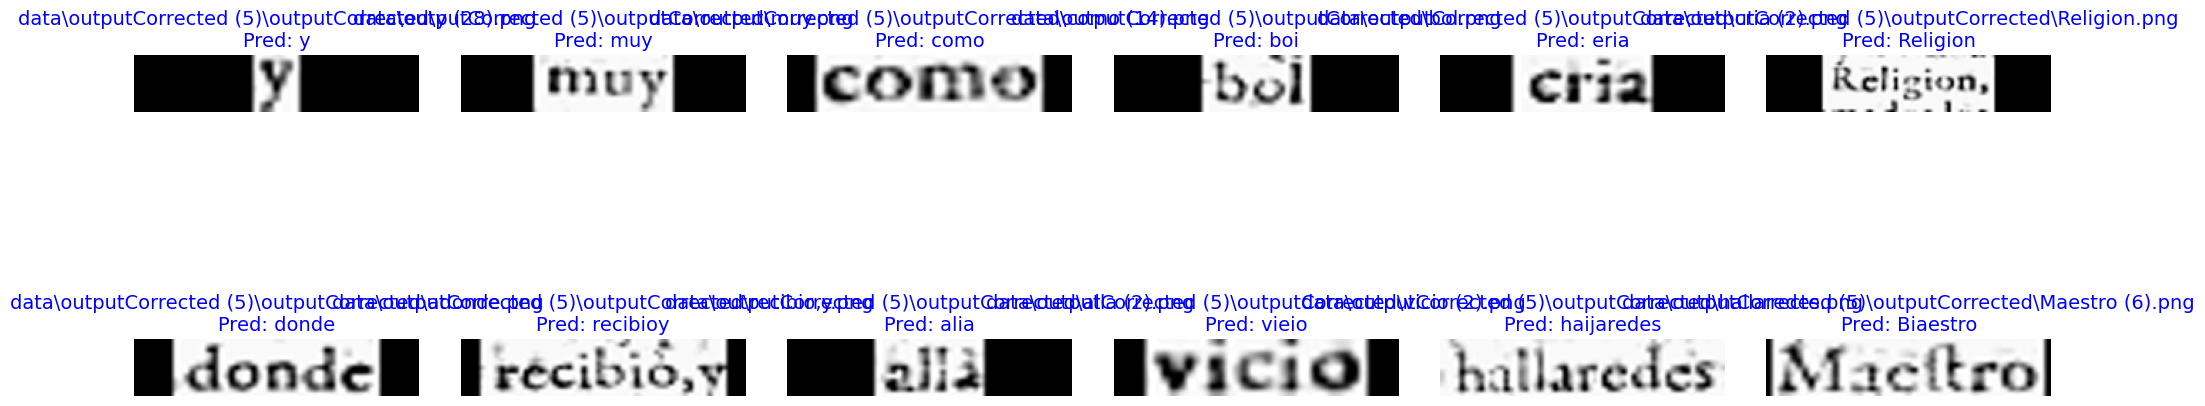

In [100]:
import torch
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild the model and load saved weights
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

with torch.no_grad():
    images, paths = next(iter(test_loader))
    images = images.to(DEVICE)
    outputs = model(images)
    preds = decode(outputs)  # Greedy decoder

    num_images = min(12, len(images))
    cols = 6
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(20, rows * 4))

    for i in range(num_images):
        img_np = images[i].cpu().squeeze().numpy() * 0.5 + 0.5
        pred = preds[i]
        img_name = paths[i].split('/')[-1]  # filename only

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"{img_name}\nPred: {pred}", fontsize=14, color='blue')
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()


Visually Inspect Misidentified Samples To See if any Data is Mislabelled

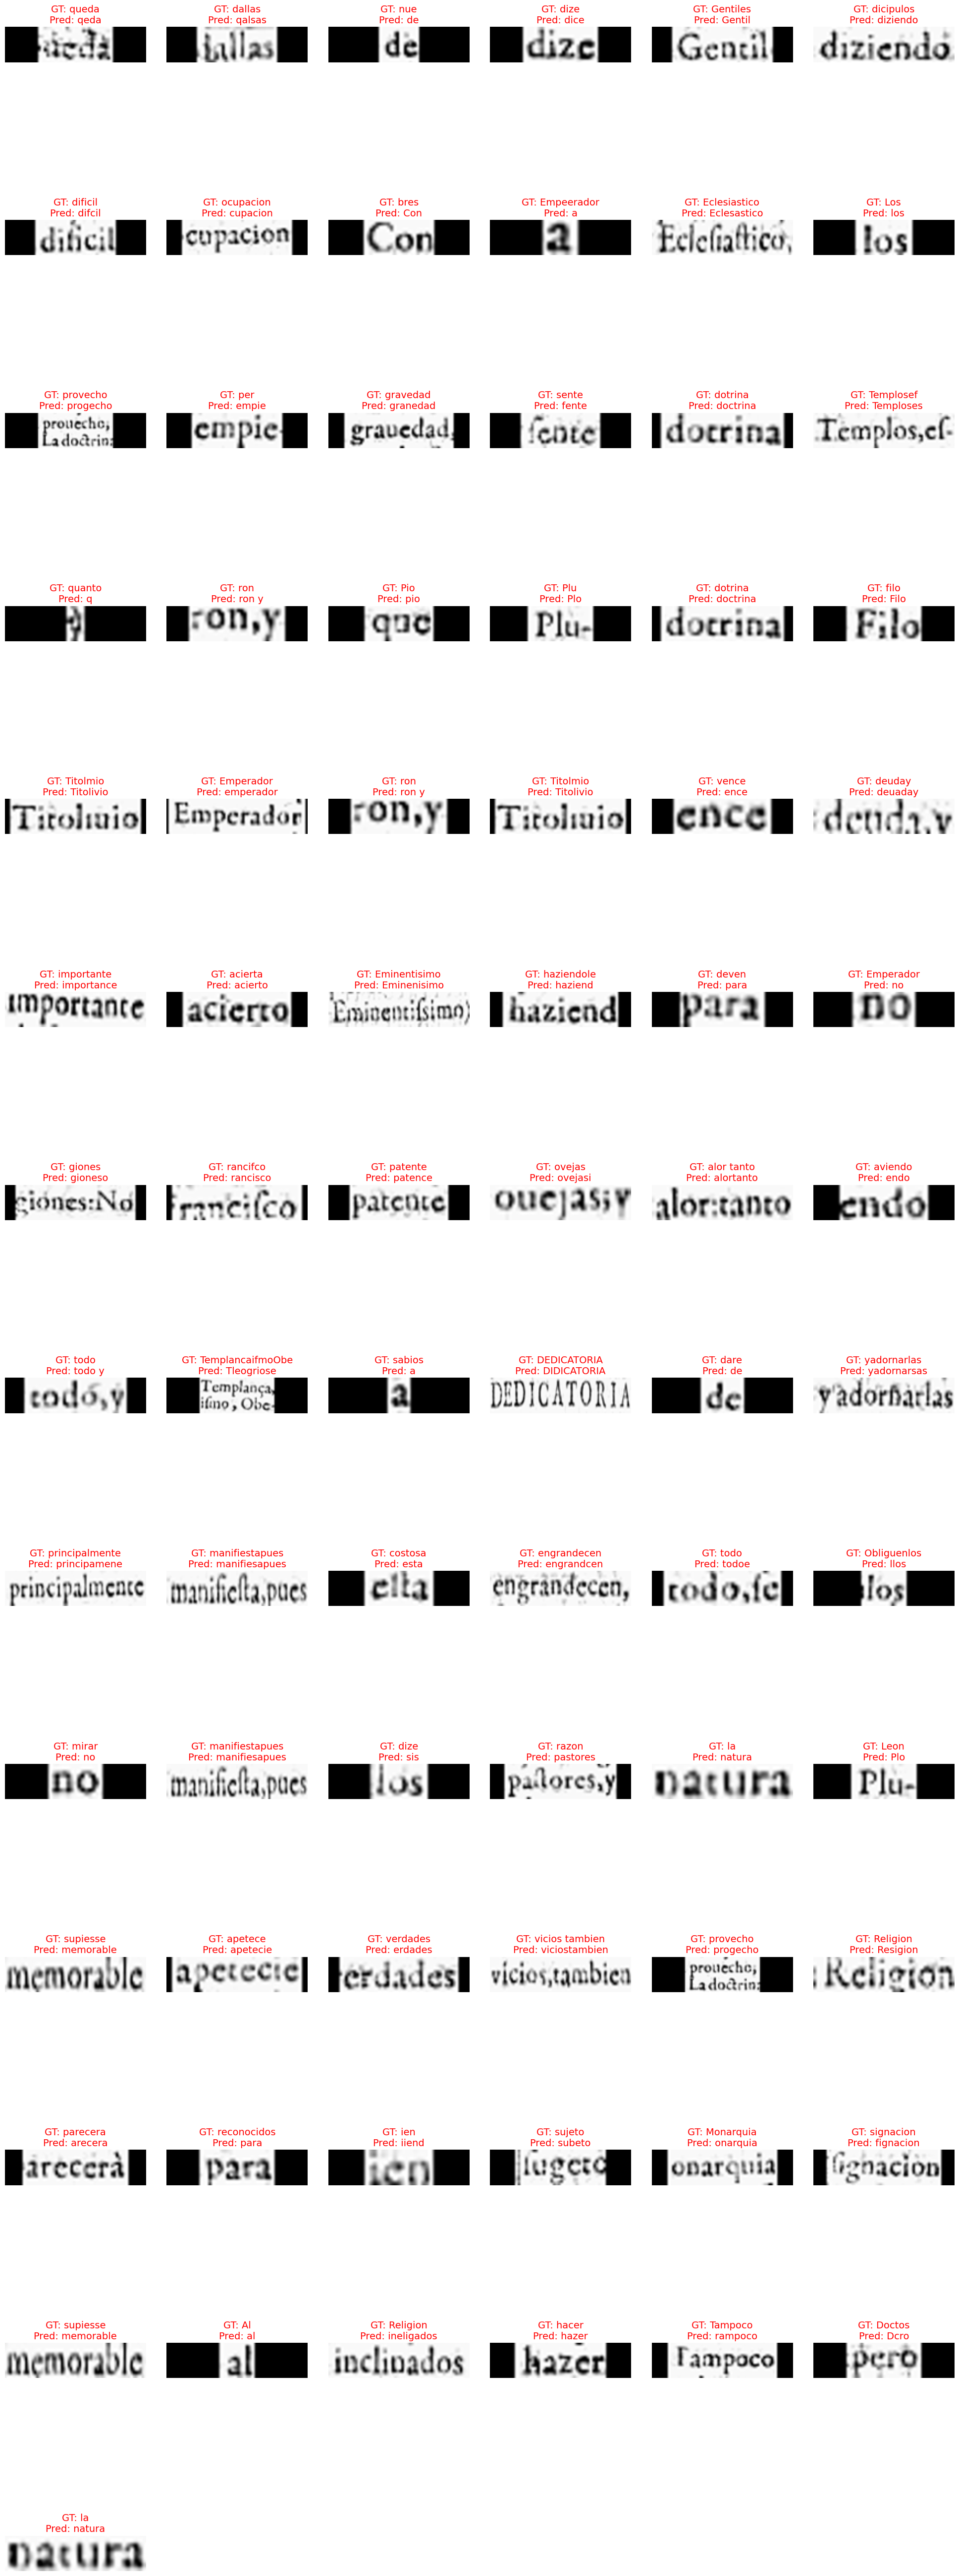

In [101]:
import torch
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Accumulate misclassified samples
misclassified = []

with torch.no_grad():
    for images, _, _, label_strs in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = decode(outputs)  # Your greedy decoder

        for i in range(len(images)):
            gt = label_strs[i]
            pred = preds[i]
            if gt != pred:
                misclassified.append((images[i].cpu(), gt, pred))

# Display misclassified images
num_images = len(misclassified)
if num_images == 0:
    print("All predictions are correct!")
else:
    cols = 6
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(20, rows * 4))

    for idx, (img, gt, pred) in enumerate(misclassified):
        img_np = img.squeeze().numpy() * 0.5 + 0.5  # unnormalize
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"GT: {gt}\nPred: {pred}", color='red', fontsize=14)
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()
